In [1]:
from dotenv import load_dotenv
import os
import time
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np 
from Preprocessing.preprocessing_pipeline_final import preprocessing_pipeline
import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')

load_dotenv()  # lädt .env automatisch
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")



In [ ]:
# Standardmäßig werden alle Zeilen angezeigt, egal, wie viele es sind
pd.set_option("display.max_columns", None)

In [77]:
def call_llm(text):
    # Diese Funktion nutzt die API von Google um sich gegen das LLM zu schalten. Prompt etc. ist unten zu sehen

    llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-001", #
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2
    )

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                '''Du bist ein Experte für Automobilklassifikation. Deine Aufgabe ist es, Automodelle basierend auf ihrem Namen einem von fünf vordefinierten Fahrzeugsegmenten zuzuordnen. Bitte gib nur den Namen des passenden Segments zurück.

                    Die Segmente sind:

                    1. Kleinwagen – kleine Stadtautos, z.B. VW Up!, Renault Clio, Fiat Panda
                    2. Mittelklasse – normale Alltagsautos, z.B. VW Golf, Audi A4, BMW 3er
                    3. Geländewagen – große Fahrzeuge mit viel Platz, z.B. BMW X3, VW Tiguan, Ford Kuga, VW Multivan
                    4. Sportwagen – sportliche Fahrzeuge mit viel PS, z.B.  BMW M4, Ford Mustang, Audi TT
                    5. Luxusklasse – hochwertige Fahrzeuge mit Premiumausstattung, z.B. BMW 7er, Mercedes S-Klasse, Tesla Model S
                    6. Luxus Geländewagen - große Fahrzeuge mit viel Platz und einer Luxuriösen Ausstattung, z.B. Mercedes-Benz G 63 AMG, BMW X5 M, Land Rover Range Rover,Porsche Cayenne
                    7. Supersportwagen - sportliche Fahrzeuge mit sehr viel PS und Leistung Mercedes-Benz E 63 AMG, Porsche 992, Porsche 911, Audi R8
                    

                    Beispiele:
                    
                    Input: smart forTwo
                    Output: Kleinwagen

                    Input: Volkswagen Golf  
                    Output: Mittelklasse

                    Input: BMW X5  
                    Output: Geländewagen

                    Input: Porsche 911  
                    Output: Sportwagen

                    Input: Bentley Mulsanne
                    Output: Luxusklasse

                Gib mir als Output nur das Fahrzeugsegment aus.                             
                ''',
            ),
            ("human", "{input}"),
        ]
    )

    chain = prompt | llm
    res = chain.invoke(
        {
            "input": text
        }
    )

    return res.content

'''
def use_llm_on_model(model_list):
    # Diese Funktion ruft die call_llm Funktion auf, um der Spalte model das Fahrzeugsegment zuzuordnen

    result = {}
    counter = 0
    limit_per_minute = 15 # brauchen diesen Timer um nicht zu viele Anfragen zu stellen (free sind 15 Anfragen/Min)

    for idx, model in enumerate(model_list, start=1):
        result[model] = call_llm(model)
        counter += 1

        # Warten, wenn das Limit erreicht ist
        if counter % limit_per_minute == 0:
            print(f"{counter} Anfragen gestellt – warte 60 Sekunden, um Rate Limit einzuhalten...")
            time.sleep(60)

    print("Fertig!")
    return result
'''
def use_llm_on_model(model_list):
    # Diese Funktion ruft die call_llm Funktion auf, um der Spalte model das Fahrzeugsegment zuzuordnen

    result = {}

    for model in (model_list):
        result[model] = call_llm(model)

    return result

In [69]:
import concurrent.futures

def use_llm_on_model_parallel(model_list, max_workers=5):
    result = {}

    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_model = {executor.submit(call_llm, model): model for model in model_list}
        
        for future in concurrent.futures.as_completed(future_to_model):
            model = future_to_model[future]
            try:
                result[model] = future.result()
            except Exception as e:
                result[model] = f"Error: {e}"

    return result

In [2]:
X_train, X_test, y_train, y_test , X,y, categorical_features , numeric_features = preprocessing_pipeline()

In [3]:
df = pd.concat([X, y], axis=1)

In [4]:
model_ps_list = df[['model', 'power_ps']].drop_duplicates().values.tolist()

In [5]:
model_ps_list

[['Alfa Romeo Giulietta', 170.0],
 ['Alfa Romeo Giulietta', 120.0],
 ['Alfa Romeo Giulietta', 235.0],
 ['Alfa Romeo Giulietta', 140.0],
 ['Alfa Romeo Giulietta', 105.0],
 ['Alfa Romeo Giulietta', 150.0],
 ['Alfa Romeo Giulietta', 241.0],
 ['Alfa Romeo Giulietta', 209.0],
 ['Alfa Romeo Giulietta', 175.0],
 ['Alfa Romeo Giulia', 179.0],
 ['Alfa Romeo Stelvio', 209.0],
 ['Alfa Romeo Stelvio', 280.0],
 ['Alfa Romeo Giulia', 209.0],
 ['Alfa Romeo Giulia', 200.0],
 ['Alfa Romeo Stelvio', 200.0],
 ['Alfa Romeo Giulia', 510.0],
 ['Alfa Romeo Giulia', 280.0],
 ['Alfa Romeo Giulia', 136.0],
 ['Alfa Romeo Stelvio', 179.0],
 ['Alfa Romeo Stelvio', 510.0],
 ['Alfa Romeo Stelvio', 190.0],
 ['Alfa Romeo Stelvio', 150.0],
 ['Alfa Romeo Stelvio', 160.0],
 ['Alfa Romeo Giulia', 150.0],
 ['Alfa Romeo Giulia', 160.0],
 ['Alfa Romeo Giulia', 201.0],
 ['Alfa Romeo Giulia', 190.0],
 ['Alfa Romeo Stelvio', 201.0],
 ['Audi A4', 90.0],
 ['Audi A4', 101.0],
 ['Audi A8', 299.0],
 ['Audi A3', 101.0],
 ['Audi TT', 

In [59]:
df[(df['model'] == 'Alfa Romeo Stelvio') & (df['power_ps'] > 250)].sort_values(by = 'power_ps', ascending=False)

,brand,model,color,year,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description,registration_month,registration_year,outlier_model_price,outlier_model_mileage,offer_description_cleaned,has_acc,has_additional_motortechnology,has_all_wheel_drive,has_assistence_systems,has_dab_radio,has_diesel_particel_feature,has_doubleclutch_transmission,has_heated_seats,has_leather_interior,has_navigation,has_panoramic_roof,has_sport_features,has_trailer_hitch,has_tuev,is_cabrio,is_combi,is_coupe,price_in_euro,segment
1249,alfa-romeo,Alfa Romeo Stelvio,black,2023,375.0,510.0,Automatic,Petrol,10.0,229.0,10.0,Quadrifoglio Q4 510PS *21Zoll LM*,6,2023,False,False,quadrifoglio q ps zoll lm,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,87980,Geländewagen
799,alfa-romeo,Alfa Romeo Stelvio,black,2019,375.0,510.0,Automatic,Petrol,9.0,210.0,51336.0,Quadrifoglio Q4,3,2019,False,False,quadrifoglio q,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,59900,Geländewagen
1102,alfa-romeo,Alfa Romeo Stelvio,red,2022,375.0,510.0,Automatic,Petrol,10.0,229.0,20.0,"Quadrifoglio, 21"",Schiebedach,NP:107.090",7,2022,False,False,quadrifoglio schiebedachnp,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,87990,Geländewagen
1103,alfa-romeo,Alfa Romeo Stelvio,red,2022,375.0,510.0,Automatic,Petrol,11.8,267.0,25.0,Quadrifoglio MY 22 NP 105.600 EUR!,12,2022,False,False,quadrifoglio my np eur,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,89460,Geländewagen
848,alfa-romeo,Alfa Romeo Stelvio,grey,2020,375.0,510.0,Automatic,Petrol,10.0,229.0,36150.0,Quadrifoglio V6 Bi-Turbo 2.9T 375KW (510PS) AT...,2,2020,False,False,quadrifoglio v biturbo t kw ps atq,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,60890,Geländewagen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
856,alfa-romeo,Alfa Romeo Stelvio,grey,2020,206.0,280.0,Automatic,Petrol,7.1,161.0,57599.0,Lusso Ti Q4 280PS,4,2020,False,False,lusso ti q ps,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,42900,Geländewagen
863,alfa-romeo,Alfa Romeo Stelvio,red,2020,206.0,280.0,Automatic,Petrol,6.9,157.0,23900.0,2.0 Turbo 16V AT8-Q4 Veloce 280PS,6,2020,False,False,turbo v atq veloce ps,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,51900,Geländewagen
903,alfa-romeo,Alfa Romeo Stelvio,violet,2020,206.0,280.0,Automatic,Petrol,7.2,165.0,18905.0,2.0 Turbo 16V AT8-Q4 Ti,10,2020,False,False,turbo v atq ti,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,34900,Geländewagen
911,alfa-romeo,Alfa Romeo Stelvio,white,2020,206.0,280.0,Automatic,Petrol,8.0,186.0,23800.0,"2.0 Turbo Q4 ""Lusso""NAVI 20"" XEN Kamera",6,2020,False,False,turbo q lussonavi xen kamera,False,True,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,38890,Geländewagen


In [72]:
model_list = df['model'].unique().tolist()
result = use_llm_on_model_parallel(model_list)
df["segment"] = df["model"].map(result).fillna("unknown")

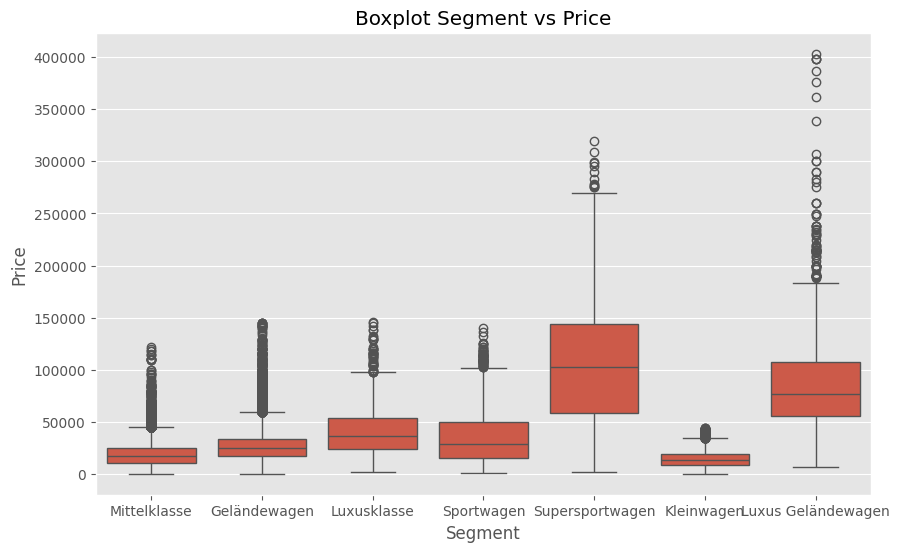

In [73]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='segment', y='price_in_euro')

plt.title("Boxplot Segment vs Price")
plt.xlabel("Segment")
plt.ylabel("Price")
#plt.tight_layout()
plt.show()

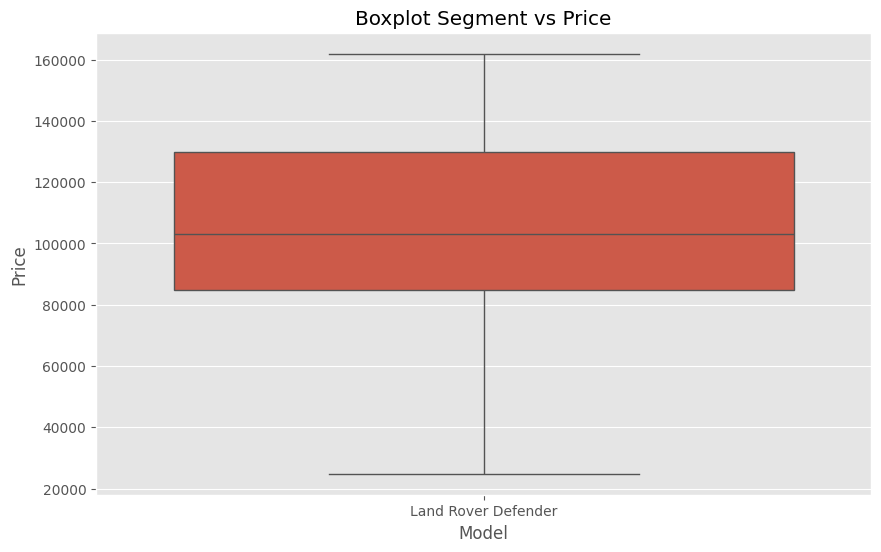

In [80]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[df['model'] == 'Land Rover Defender'], x='model', y='price_in_euro')

plt.title("Boxplot Segment vs Price")
plt.xlabel("Model")
plt.ylabel("Price")
#plt.tight_layout()
plt.show()

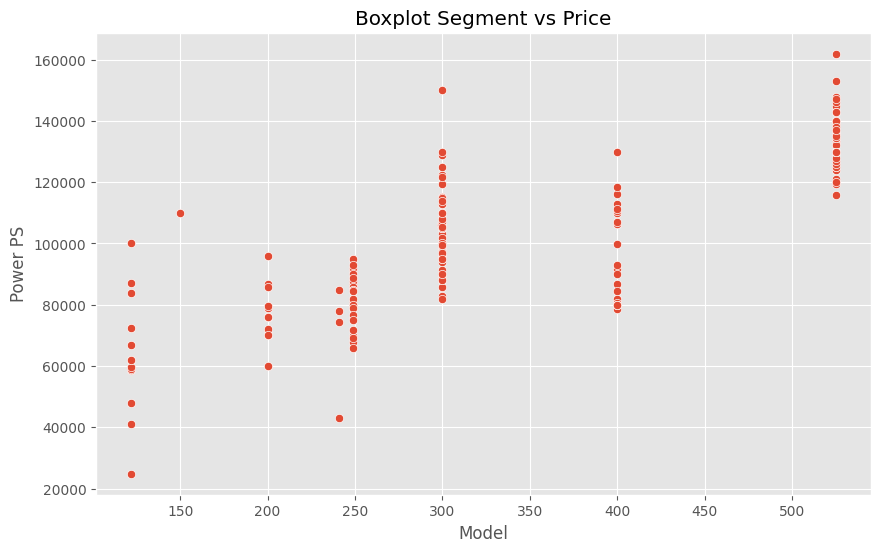

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df[df['model'] == 'Land Rover Defender'], x='power_ps', y='price_in_euro')

plt.title("Boxplot Segment vs Price")
plt.xlabel("Power PS")
plt.ylabel("Price")
#plt.tight_layout()
plt.show()

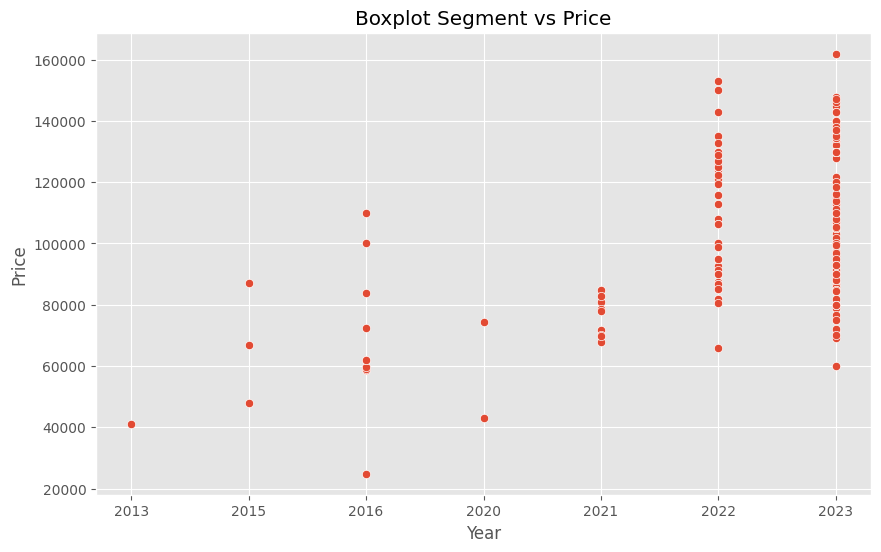

In [83]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df[df['model'] == 'Land Rover Defender'], x='year', y='price_in_euro')

plt.title("Boxplot Segment vs Price")
plt.xlabel("Year")
plt.ylabel("Price")
#plt.tight_layout()
plt.show()

In [75]:
df[df['segment'] == 'Geländewagen'].sort_values(by = 'price_in_euro', ascending=False)

,brand,model,color,year,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description,registration_month,registration_year,outlier_model_price,outlier_model_mileage,offer_description_cleaned,has_acc,has_additional_motortechnology,has_all_wheel_drive,has_assistence_systems,has_dab_radio,has_diesel_particel_feature,has_doubleclutch_transmission,has_heated_seats,has_leather_interior,has_navigation,has_panoramic_roof,has_sport_features,has_trailer_hitch,has_tuev,is_cabrio,is_combi,is_coupe,price_in_euro,segment
150287,porsche,Porsche Cayenne,black,2018,324.0,441.0,Automatic,Petrol,9.2,209.0,67820.0,S ''21-Zoll Panorama Luftfederung BOSE'',7,2018,False,False,s zoll panorama luftfederung bose,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,145000,Geländewagen
151159,porsche,Porsche Cayenne,grey,2022,338.0,460.0,Automatic,Petrol,11.2,256.0,17000.0,"Coupe GTS SportDesign HUD SPORTABGAS 22""",1,2022,False,False,coupe gts sportdesign hud sportabgas,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,144950,Geländewagen
150772,porsche,Porsche Cayenne,silver,2019,404.0,549.0,Automatic,Petrol,11.4,261.0,58938.0,Turbo Clubleder HA-Lenkung LED 22-Zoll,2,2019,False,False,turbo clubleder halenkung led zoll,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,144900,Geländewagen
151197,porsche,Porsche Cayenne,red,2022,471.0,640.0,Automatic,Petrol,11.9,271.0,13122.0,Coupe GTS BOSE PANO TOTW TV SP.CHRONO,6,2022,False,False,coupe gts bose pano totw tv spchrono,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,144900,Geländewagen
151402,porsche,Porsche Cayenne,black,2023,338.0,460.0,Automatic,Petrol,13.2,308.0,19900.0,"GTS 22"";Matrix;360°; Standheiz.",5,2023,False,False,gts matrix standheiz,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,143890,Geländewagen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124900,opel,Opel Zafira,grey,2005,92.0,125.0,Manual,Petrol,8.6,204.0,229484.0,"A 1,8 Alu KLimaautomatik Sitzheizung",4,2005,False,False,a alu klimaautomatik sitzheizung,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,590,Geländewagen
151420,renault,Renault Scenic,blue,2000,79.0,107.0,Manual,Petrol,7.4,175.0,149000.0,Megane 1.6 Kaleido,2,2000,False,False,megane kaleido,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,500,Geländewagen
151424,renault,Renault Scenic,blue,2001,79.0,107.0,Manual,Petrol,7.5,178.0,142407.0,1.6 16V Privilege,8,2001,False,False,v privilege,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,350,Geländewagen
151444,renault,Renault Scenic,blue,2001,79.0,107.0,Manual,Petrol,7.5,178.0,142401.0,1.6 16V Emotion,8,2001,False,False,v emotion,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,350,Geländewagen


In [52]:
df[df['model'] == 'Land Rover Defender'].sort_values(by = 'price_in_euro', ascending=False)

,brand,model,color,year,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description,registration_month,registration_year,outlier_model_price,outlier_model_mileage,offer_description_cleaned,has_acc,has_additional_motortechnology,has_all_wheel_drive,has_assistence_systems,has_dab_radio,has_diesel_particel_feature,has_doubleclutch_transmission,has_heated_seats,has_leather_interior,has_navigation,has_panoramic_roof,has_sport_features,has_trailer_hitch,has_tuev,is_cabrio,is_combi,is_coupe,price_in_euro,segment
86091,land-rover,Land Rover Defender,black,2023,386.0,525.0,Automatic,Petrol,12.9,290.0,42.0,110 V8 P525 Edition Meridian Panorama,2,2023,False,False,v p edition meridian panorama,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,161900,Geländewagen
85584,land-rover,Land Rover Defender,grey,2022,386.0,525.0,Automatic,Petrol,12.8,290.0,75.0,110 V8 P525 Carpathian Edition Tagzul.,5,2022,False,False,v p carpathian edition tagzul,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,152900,Geländewagen
85737,land-rover,Land Rover Defender,black,2022,221.0,300.0,Automatic,Diesel,7.6,247.0,8500.0,"130 D300X 22""8-Sitze AHK Standh.Black-P",10,2022,False,False,dx sitze ahk standhblackp,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,149900,Geländewagen
85961,land-rover,Land Rover Defender,grey,2023,386.0,525.0,Automatic,Petrol,14.8,334.0,11.0,V8 Carpathian Edition GREY/BLACK 2023,6,2023,False,False,v carpathian edition greyblack,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,147810,Geländewagen
85997,land-rover,Land Rover Defender,grey,2023,386.0,525.0,Automatic,Petrol,14.8,334.0,1000.0,110 P525 V8 Carpathian Edition,3,2023,False,False,p v carpathian edition,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,146990,Geländewagen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83661,land-rover,Land Rover Defender,black,2016,90.0,122.0,Manual,Diesel,10.0,265.0,35000.0,90 DPF Station Wagon SE AHK Klima LM,3,2016,False,False,dpf station wagon se ahk klima lm,True,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,58730,Geländewagen
83537,land-rover,Land Rover Defender,black,2015,90.0,122.0,Manual,Diesel,10.0,265.0,25800.0,3.0 TDV6 VOGUE*PAN*NAVi*LEDER*KAMERA,10,2015,False,False,tdv voguepannavilederkamera,False,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,False,47999,Geländewagen
85379,land-rover,Land Rover Defender,black,2020,177.0,241.0,Automatic,Diesel,7.6,199.0,29000.0,2.0 D240 S 110 **KAMERA LEDER 6-SITZE**,5,2020,False,False,d s kamera leder sitze,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,42900,Geländewagen
83404,land-rover,Land Rover Defender,black,2013,90.0,122.0,Manual,Diesel,10.0,265.0,25874.0,90 ORIGINAL PROJEKT - KAHN - CHELSEA,10,2013,False,False,original projekt kahn chelsea,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,40999,Geländewagen


In [ ]:
df[df['model'] == 'Audi R8'].sort_values(by = 'price_in_euro', ascending=False)

In [42]:
df[(df['brand'] == 'audi') & (df['power_ps'] < 250)].sort_values(by = 'power_ps', ascending=False)

,brand,model,color,year,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description,registration_month,registration_year,outlier_model_price,outlier_model_mileage,offer_description_cleaned,has_acc,has_additional_motortechnology,has_all_wheel_drive,has_assistence_systems,has_dab_radio,has_diesel_particel_feature,has_doubleclutch_transmission,has_heated_seats,has_leather_interior,has_navigation,has_panoramic_roof,has_sport_features,has_trailer_hitch,has_tuev,is_cabrio,is_combi,is_coupe,price_in_euro,segment
8689,audi,Audi Q3,red,2014,182.0,247.0,Manual,Petrol,7.3,173.0,150000.0,2.0 TFSI quattro (8UB) S.Line-Xenon-Navi,8,2014,False,False,tfsi quattro ub slinexenonnavi,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,16500,Geländewagen
7217,audi,Audi Q5,grey,2013,180.0,245.0,Automatic,Diesel,6.4,170.0,166000.0,"3.0 ""QUATTRO""| PANORAMA| KAMERA| eAHK| KEY-G|",1,2013,False,False,quattro panorama kamera eahk keyg,False,False,True,True,False,False,False,False,False,False,True,False,True,False,False,False,False,20549,Geländewagen
4928,audi,Audi A7,black,2010,180.0,245.0,Automatic,Diesel,5.9,156.0,238541.0,Sportback 3.0 TDI quattro TÜV 10/2023,10,2010,False,False,sportback tdi quattro tüv,False,True,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,13990,Luxusklasse
17168,audi,Audi TT,black,2019,180.0,245.0,Automatic,Petrol,7.0,161.0,25025.0,Coupe 45 TFSI QUATTRO*S-TRONIC*VIRTUAL,12,2019,False,False,coupe tfsi quattrostronicvirtual,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,38900,Sportwagen
9062,audi,Audi A6 allroad,black,2014,180.0,245.0,Automatic,Diesel,6.3,167.0,189870.0,Quattro 3.0 TDI*Massage*ACC*Standheiz,5,2014,False,False,quattro tdimassageaccstandheiz,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,26890,Mittelklasse
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12219,audi,Audi A1,silver,2016,60.0,82.0,Manual,Petrol,4.4,97.0,164989.0,Sportback Klima Sitzheiz. BT-Tel. M+S,5,2016,False,False,sportback klima sitzheiz bttel ms,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,10999,Kleinwagen
12218,audi,Audi A1,silver,2016,60.0,82.0,Manual,Petrol,4.4,98.0,69000.0,"Sportback S-Line,Xenon,Media-Paket,Sitzh,Pdc",12,2016,False,False,sportback slinexenonmediapaketsitzhpdc,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,15490,Kleinwagen
15164,audi,Audi A1,red,2018,60.0,82.0,Manual,Petrol,4.4,102.0,50000.0,design,6,2018,False,False,design,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,15300,Kleinwagen
13508,audi,Audi A1,black,2017,60.0,82.0,Manual,Petrol,4.4,97.0,35707.0,1.0 Lim. design KLIMA/XEN/NAVI/ALU,5,2017,False,False,lim design klimaxennavialu,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,15689,Kleinwagen


In [26]:
df['brand'].value_counts()

brand
volkswagen       23547
opel             15002
mercedes-benz    14637
audi             14382
ford             13494
bmw              11411
skoda            10756
seat              8942
renault           5669
hyundai           4388
peugeot           3931
kia               3789
mazda             3131
fiat              2732
porsche           2671
volvo             2465
mini              2330
land-rover        2293
toyota            2279
dacia             2142
citroen           2102
nissan            2097
jaguar            1021
smart              935
jeep               839
alfa-romeo         673
mitsubishi         329
honda              282
maserati           276
saab               101
Name: count, dtype: int64